# Машинное обучение, ФКН ВШЭ

## Практическое задание 4. Классификация

### О задании

В этом задании вы:
- ознакомитесь с тем, что происходит "внутри" метода опорных векторов и логистической регрессии
- познакомитесь с калибровкой вероятности
- изучите методы трансформации переменных и методы отбора признаков
- попробуете оценить экономический эффект модели

----

#### Самостоятельная оценка результатов

Для удобства проверки, исходя из набора решенных задач, посчитайте свою максимальную оценку.

**Оценка**: да, вроде, 10+

### Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного жёсткого дедлайна нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи

Для сдачи задания переименуйте получившийся файл *.ipynb в соответствии со следующим форматом: homework-practice-04-linclass-__Username__.ipynb, где Username — ваша фамилия и имя на латинице именно в таком порядке (например, homework-practice-04-linclass-__IvanovIvan__.ipynb).

# Часть 1. SVM, LR и калибровка вероятностей

In [ ]:
# !pip3 install --upgrade scikit-learn

In [ ]:
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
sns.set_style('whitegrid')

#### __Задание 1.1  Сравнение методов__ (0.5 балла)



Сгенерируем синтетические данные.

In [ ]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# фиксируем random_state для воспроизводимости результатов
x, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

__Случайный классификатор__

Для начала зададим самую простую модель, которая на каждом объекте выдаёт один из двух классов с равными вероятностями. По тестовой выборке вычислим AUC-ROC, AUC-PR.

In [ ]:
np.random.seed(42)

# наш случайный классификатор
y_random = np.random.choice([0, 1], size=len(y_test), p=[0.5, 0.5])
y_random

array([0, 1, 1, ..., 0, 0, 0])

*Ниже приведен **пример** работы* со встроенными функциями `sklearn` для отрисовки ROC и PR кривых, сохранения метрик. Пайплайн можно изменять как вам удобно, за особенно эффективные или красивые варианты может быть начислен небольшой бонус :)

In [ ]:
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay

from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


AUC-PR: 0.62860
AUC-ROC: 0.50959


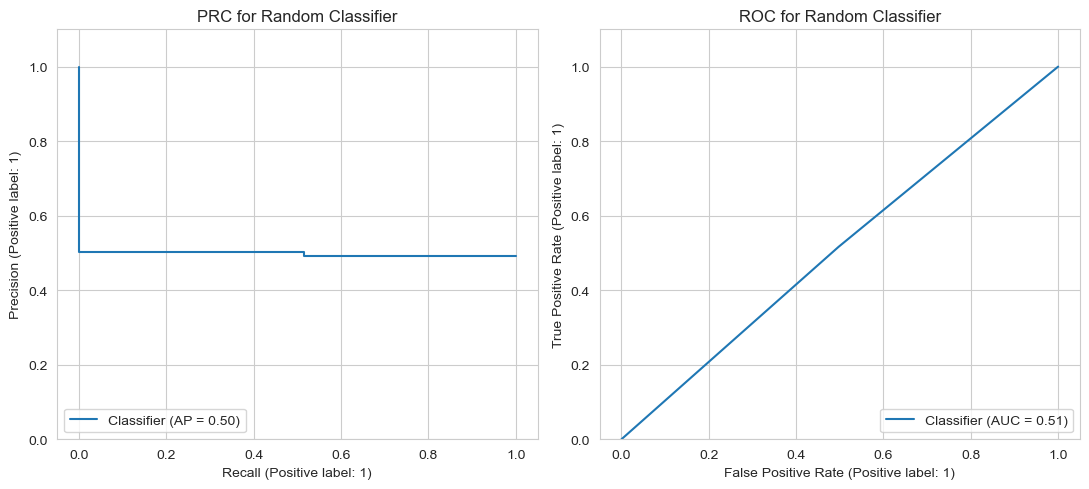

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(11, 5))

PrecisionRecallDisplay.from_predictions(y_test, y_random, ax=ax[0])
precision, recall, _ = precision_recall_curve(y_test, y_random)
print('AUC-PR: %.5f' % auc(recall, precision))
ax[0].set_title("PRC for Random Classifier")
ax[0].set_ylim(0, 1.1)

RocCurveDisplay.from_predictions(y_test, y_random, ax=ax[1])
print('AUC-ROC: %.5f' % roc_auc_score(y_test, y_random))
ax[1].set_title("ROC for Random Classifier")
ax[1].set_ylim(0, 1.1)

plt.tight_layout()

In [ ]:
# dataframe для сравнения
# методов классификации по метрикам
df_metrics = pd.DataFrame(columns=['AUC_PR', 'AUC_ROC', 'reg_const', 'time'])

# добавление очередной строки с характеристиками метода
df_metrics.loc['Random Classifier'] = [
    auc(recall, precision),
    roc_auc_score(y_test, y_random),
    None,
    None
]

# по аналогии результаты следующих экспериментов можно будет собрать в табличку
df_metrics

,AUC_PR,AUC_ROC,reg_const,time
Random Classifier,0.628598,0.509593,NaN,NaN


__Support Vector Machine (Linear Kernel)__

Обучите метод опорных векторов. На занятиях мы проходили линейный вариант без ядрового перехода, что соответствует линейному ядру (`LinearSVC` или же `SVC(kernel='linear')` в `sklearn.svm`). Подберите параметр регуляризации `C` (можете воспользоваться кросс-валидацией или отделить валидационную выборку от обучающей).

__NB!__ Здесь и далее, если не сказано иначе, подбирайте __оптимальные гиперпараметры с точки зрения AUC-PR.__

In [ ]:
from enum import Enum

class ModelTypes(Enum):
    LinearSVC = 'Linear SVC'
    SVC = 'SVC kernel linear'
    LogReg = 'Logistic Regression'

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC


def model_fit(x, y, model_name: ModelTypes, parameter = 0.1, max_iteration: int = 100000):
    if model_name == ModelTypes.LinearSVC:
        model = LinearSVC(max_iter=max_iteration, C=parameter)
    elif model_name == ModelTypes.LogReg:
        model = LogisticRegression(max_iter=max_iteration, C=parameter)
    elif model_name == ModelTypes.SVC:
        model = SVC(max_iter=max_iteration, C=parameter, kernel='linear')
    return model.fit(x, y)


def find_parameter(x_train, y_train, x_validation, y_validation,
                   model_name: ModelTypes, max_iteration: int = 100000,
                   logspace_from = -4, logspace_to = 4, logspace_count = 15) -> float:

    parameters = np.logspace(logspace_from, logspace_to, logspace_count)
    max_scrore = 0
    best_parameter = 0

    for parameter in parameters:
        model = model_fit(x_train, y_train, model_name, parameter)
        score = roc_auc_score(y_validation, model.decision_function(x_validation))
        if score > max_scrore:
            max_scrore = score
            best_parameter = parameter

    print(f"best c parameter: {best_parameter}")
    return best_parameter

In [ ]:
x_train, x_validation, y_train, y_validation = train_test_split(x_train, y_train, test_size=0.5, random_state=42)
linearsvc_parameter = find_parameter(x_train, y_train, x_validation, y_validation, ModelTypes.LinearSVC)

/Users/neudachina/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/neudachina/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/neudachina/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/neudachina/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


best c parameter: 51.79474679231202


/Users/neudachina/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


  На тестовой части:
  - постройте ROC и PR кривые,
  - посчитайте AUC-ROC, AUC-PR с точностью до 5 знаков

In [ ]:
def draw_rpc_roc_auc(x_train, y_train, x_test, y_test,
                model_type: ModelTypes, parameter = 0.1):

    model = model_fit(x_train, y_train, model_type, parameter)
    test_predicted = model.decision_function(x_test)

    fig, ax = plt.subplots(1, 2, figsize=(11, 5))

    PrecisionRecallDisplay.from_predictions(y_test, test_predicted, ax=ax[0])
    precision, recall, _ = precision_recall_curve(y_test, test_predicted)

    pr_auc = auc(recall, precision)
    print('AUC-PR: %.5f' % pr_auc)

    ax[0].set_title(f"PRC for {model_type.value}")
    ax[0].set_ylim(0, 1.1)


    RocCurveDisplay.from_predictions(y_test, test_predicted, ax=ax[1])
    auc_score = roc_auc_score(y_test, test_predicted)
    print('AUC-ROC: %.5f' % auc_score)
    ax[1].set_title(f"ROC for {model_type.value}")
    ax[1].set_ylim(0, 1.1)

    plt.tight_layout()

    return pr_auc, auc_score

/Users/neudachina/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


AUC-PR: 0.82590
AUC-ROC: 0.84434


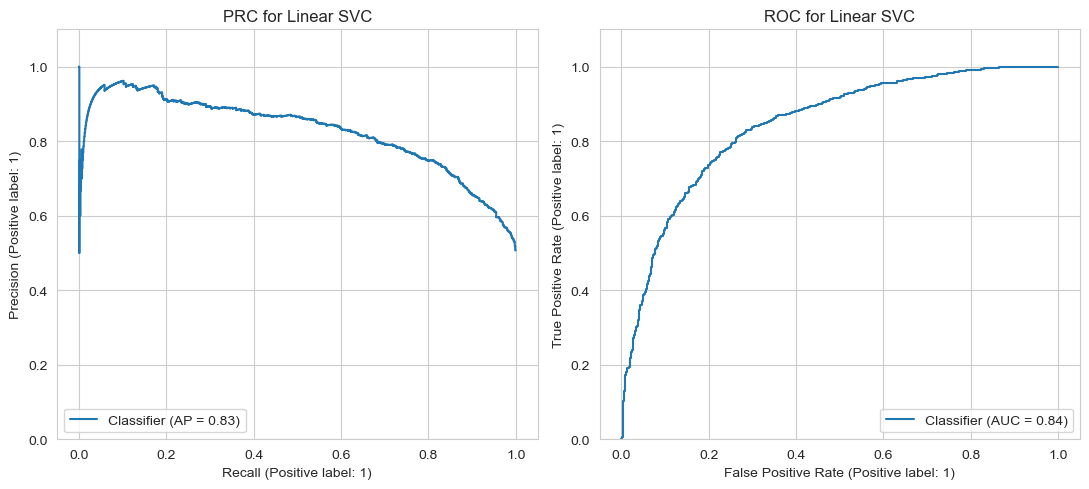

In [ ]:
pr_auc, auc_score = draw_rpc_roc_auc(x_train, y_train, x_test, y_test, ModelTypes.LinearSVC, linearsvc_parameter)

Сравните AUC-ROC и AUC-PR для вашей модели с этими же метриками для случайного классификатора.

In [ ]:
df_metrics.loc[ModelTypes.LinearSVC.value] = [
    pr_auc,
    auc_score,
    linearsvc_parameter,
    None
]

df_metrics

,AUC_PR,AUC_ROC,reg_const,time
Random Classifier,0.628598,0.509593,NaN,NaN
Linear SVC,0.825903,0.844337,51.794747,NaN


получили лучшее значения что для ROC AUC, что для PR AUC. класс!

__Logistic Regression__

Теперь повторите то же самое для логистической регрессии (LR) — обучение, подбор параметра регуляризации (используйте L2-регуляризацию), вычисление метрик и построение кривых ROC и PR.

best c parameter: 0.2682695795279725
AUC-PR: 0.82491
AUC-ROC: 0.84478


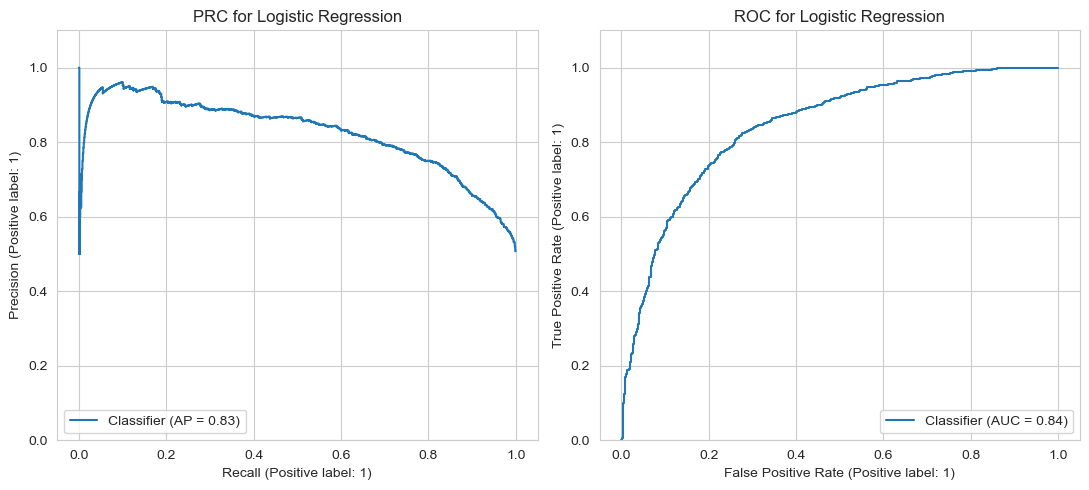

In [ ]:
logreg_parameter = find_parameter(x_train, y_train, x_validation, y_validation, ModelTypes.LogReg)
pr_auc, auc_score = draw_rpc_roc_auc(x_train, y_train, x_test, y_test, ModelTypes.LogReg, logreg_parameter)

In [ ]:
df_metrics.loc[ModelTypes.LogReg.value] = [
    pr_auc,
    auc_score,
    logreg_parameter,
    None
]
df_metrics

,AUC_PR,AUC_ROC,reg_const,time
Random Classifier,0.628598,0.509593,NaN,NaN
Linear SVC,0.825903,0.844337,51.794747,NaN
Logistic Regression,0.824907,0.844776,0.268270,NaN


__Микровывод__

  Сравните результаты LR и SVM с точки зрения всех вычисленных критериев качества, объясните различия (если они есть).

  Ответ: различий практически нет...

#### __Задание 1.2. Визуализация в подходах SVM, LR__ (0.5 балла)

В названии метода опорных векторов присутствуют некоторые "опорные векторы". По сути, это объекты из обучающей выборки, которые задали положение разделяющей гиперплоскости.

1) Сгенерируйте синтетические данные с помощью `make_classification` __с 2 признаками__, обучите на нём метод опорных векторов. В этот раз воспользуйтесь `SVC(kernel='linear')`, так как только в нём есть информация об опорных векторах, а в `LinearSVC` нет.

2) Визуализируйте разделяющую прямую, все объекты и выделите опорные векторы (атрибут `support_vectors_`).

In [ ]:

def create_synthtic_data(n_features, n_informative, n_redundant, samples = 10000):
    x, y = make_classification(
        n_samples=samples, n_features=n_features, n_informative=n_informative, n_redundant=n_redundant, random_state=42)

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

    x_train, x_validation, y_train, y_validation = train_test_split(
        x_train, y_train, test_size=0.5, random_state=42
    )

    return x_train, y_train, x_validation, y_validation, x_test, y_test

In [ ]:
s_x_train, s_y_train, s_x_validation, s_y_validation, s_x_test, s_y_test = create_synthtic_data(2, 2, 0)
parameter = find_parameter(s_x_train, s_y_train, s_x_validation, s_y_validation, ModelTypes.SVC)

/Users/neudachina/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/neudachina/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/neudachina/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/neudachina/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


best c parameter: 1.0


/Users/neudachina/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


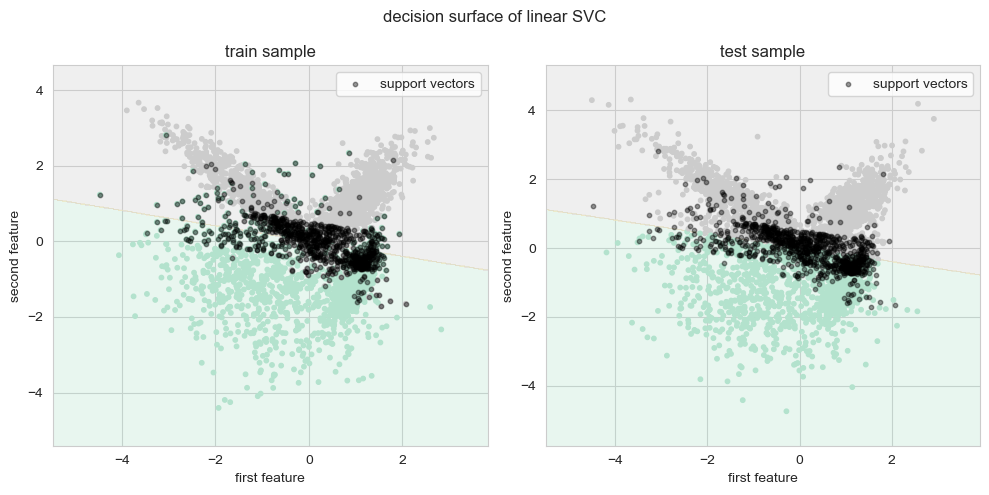

In [ ]:
def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, model, x, y, **params):
    z = model.predict(np.c_[x.ravel(), y.ravel()])
    z = z.reshape(x.shape)
    ax.contourf(x, y, z, **params)


model = model_fit(s_x_train, s_y_train, ModelTypes.SVC, parameter)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle("decision surface of linear SVC")

x_samples = [s_x_train, s_x_test]
y_samples = [s_y_train, model.predict(s_x_test)]
samples = ['train', 'test']

for i in range(2):
    x0, x1 = x_samples[i][:, 0], x_samples[i][:, 1]

    x, y = make_meshgrid(x0, x1)
    plot_contours(ax[i], model, x, y, cmap=plt.cm.Pastel2, alpha=0.3)

    ax[i].scatter(x0, x1, c=y_samples[i], cmap=plt.cm.Pastel2, s=10)

    support_vectors = model.support_vectors_
    ax[i].scatter(support_vectors[:,0], support_vectors[:,1], label='support vectors', alpha=0.4, s=10, color='black')

    ax[i].set_ylabel('second feature')
    ax[i].set_xlabel('first feature')
    ax[i].set_title(f'{samples[i]} sample')
    ax[i].legend()

plt.tight_layout()

В отличие от метода опорных векторов, логистическая регрессия не пытается построить разделяющую гиперплоскость с максимальным отступом, а приближает в каждой точке пространства объектов вероятность положительных ответов $p(y=+1|x)$. Попробуйте нарисовать это распределение на плоскости, не забудьте отметить на ней все объекты. Вам может помочь функция `plt.pcolor` ([matplotlib demo](https://matplotlib.org/3.1.1/gallery/images_contours_and_fields/pcolor_demo.html#sphx-glr-gallery-images-contours-and-fields-pcolor-demo-py)).

best c parameter: 13.89495494373136


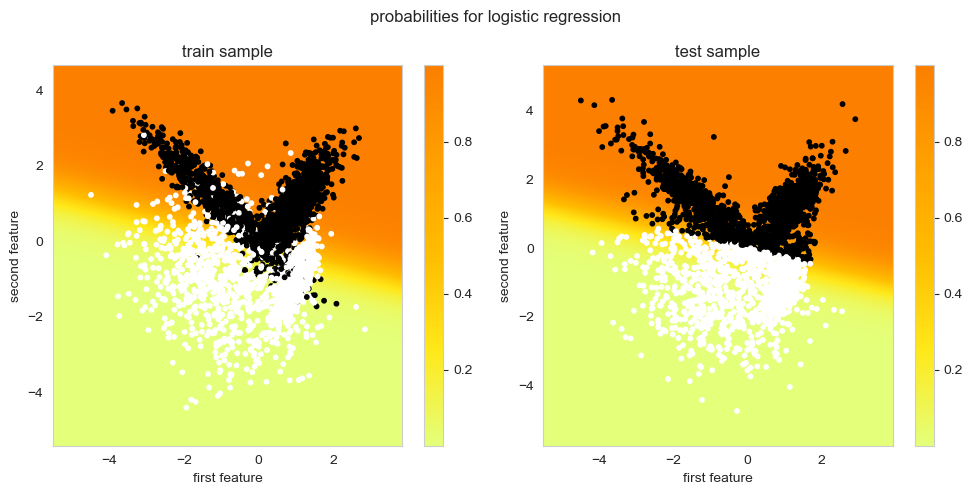

In [ ]:
model = model_fit(s_x_train, s_y_train, ModelTypes.LogReg,
                  find_parameter(s_x_train, s_y_train, s_x_validation, s_y_validation, ModelTypes.LogReg))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle("probabilities for logistic regression")

x_samples = [s_x_train, s_x_test]
y_samples = [s_y_train, model.predict(s_x_test)]
samples = ['train', 'test']

for i in range(2):
    x0, x1 = x_samples[i][:, 0], x_samples[i][:, 1]

    x, y = make_meshgrid(x0, x1)
    z = model.predict_proba(np.c_[x.ravel(), y.ravel()])[:, 1]
    z = z.reshape(x.shape)

    plot = ax[i].pcolor(x, y, z, cmap=plt.cm.Wistia)
    fig.colorbar(plot, ax=ax[i])

    ax[i].scatter(x0, x1, c=y_samples[i], cmap=plt.cm.binary, s=10)

    ax[i].set_ylabel('second feature')
    ax[i].set_xlabel('first feature')
    ax[i].set_title(f'{samples[i]} sample')

plt.tight_layout()

#### __Задание 2. Калибровка вероятностей__ (1 балл)

Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых.

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность? Для этого разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины.

Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной.

Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [ ]:
def plot_calibration_curve(y_test, preds):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((r + l) / 2)
        bin = y_test[(preds >= l) & (preds < r)]
        bin_real_ratios.append(np.sum(bin == 1) / bin.shape[0])
    plt.figure(figsize=(6,6))
    plt.plot(bin_middle_points, bin_real_ratios)
    plt.ylim([-0.05, 1.05])
    plt.grid()

Сгенерируйте синтетические данные аналогично использованным в самом первом задании. Постройте калибровочные кривые на тестовой части для логистической регрессии и метода опорных векторов (не забудьте перевести его предсказания в $[0;1]$).

In [ ]:
s_x_train, s_y_train, s_x_validation, s_y_validation, s_x_test, s_y_test = create_synthtic_data(10, 5, 5)

print(f'{ModelTypes.LinearSVC.value}')
svc_param = find_parameter(s_x_train, s_y_train, s_x_validation, s_y_validation, ModelTypes.LinearSVC)
svc = model_fit(s_x_train, s_y_train, ModelTypes.LinearSVC, svc_param)

print(f'\n{ModelTypes.LogReg.value}')
logreg_param = find_parameter(s_x_train, s_y_train, s_x_validation, s_y_validation, ModelTypes.LogReg)
logreg = model_fit(s_x_train, s_y_train, ModelTypes.LogReg, logreg_param)

svc_pred = svc.decision_function(s_x_test)
svc_pred = (svc_pred - svc_pred.min()) / (svc_pred.max() - svc_pred.min())

logreg_pred = logreg.predict_proba(s_x_test)[:, 1]

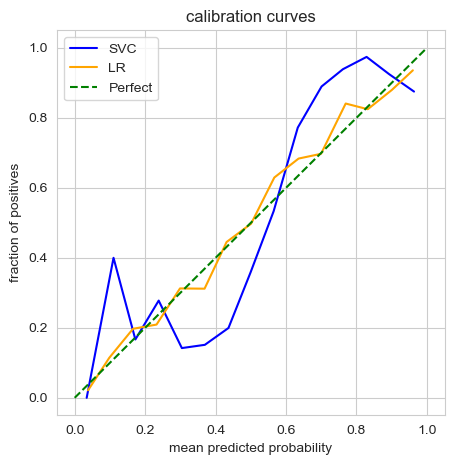

In [ ]:
plt.figure(figsize=(5, 5))

svc_true_prob, svc_pred_prob = calibration_curve(s_y_test, svc_pred, n_bins=15)
logregr_true_prob, logregr_pred_prob = calibration_curve(s_y_test, logreg_pred, n_bins=15)

plt.plot(svc_pred_prob, svc_true_prob, label='SVC', color='blue')
plt.plot(logregr_pred_prob, logregr_true_prob, label='LR', color='orange')
plt.plot([0, 1], [0, 1], label='Perfect', linestyle='--', color='green')

plt.xlabel('mean predicted probability')
plt.ylabel('fraction of positives')
plt.title('calibration curves')
plt.legend()
plt.show()

Изучите распределение ответов классификаторов (постройте гистограммы с помощью `plt.hist`).

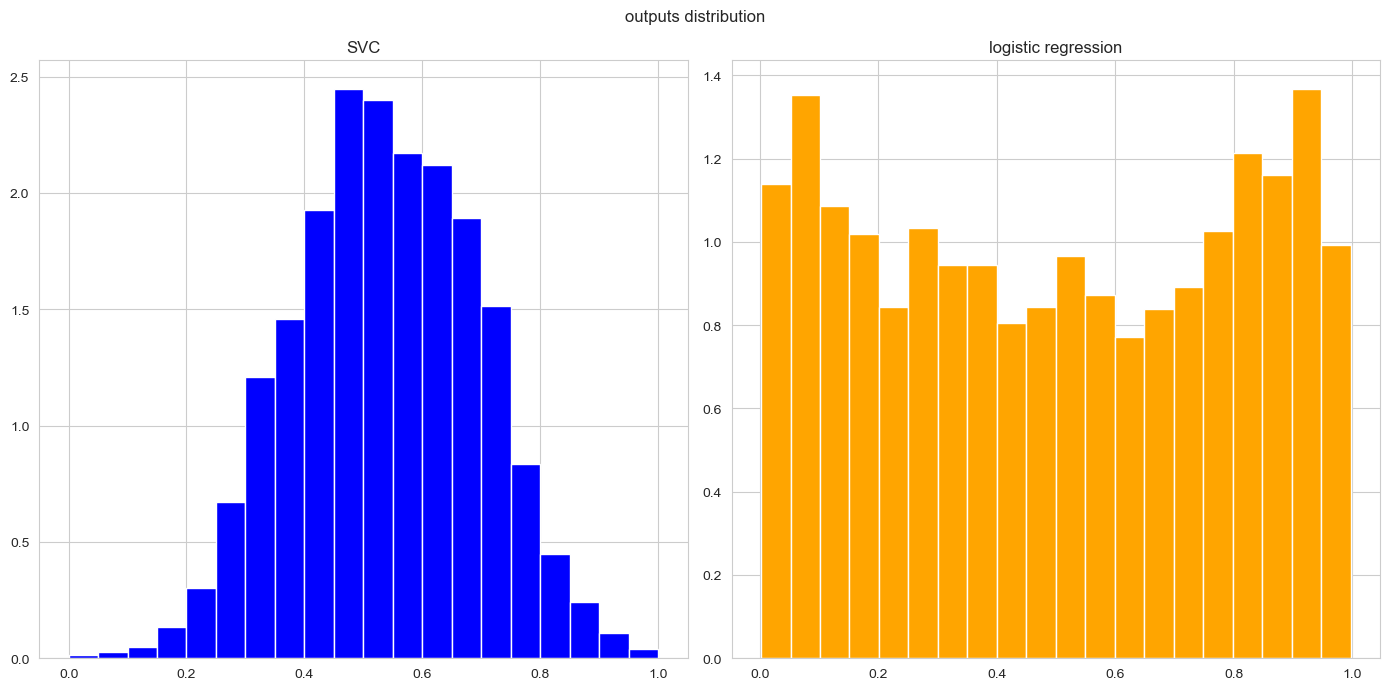

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(14, 7))

axs[0].hist(svc_pred, bins=20, color='blue', density='True')
axs[1].hist(logreg_pred, bins=20, color='orange', density='True')

axs[0].set_title('SVC')
axs[1].set_title('logistic regression')

plt.suptitle('outputs distribution')
plt.tight_layout()
plt.show()


Чем они различаются? Чем вы можете объяснить это?

Ответ: логистическая регрессия пытается для каждой точки приблизить вероятность, а для svc максимизирует минимальный отстут от прямой, разделяющей классы. поэтому и получается, что в scv большьнство точек находятся где-то около вероятности 0.5, возле самой прямой, а у лог регрессии как-то все более-менее равномерно

Воспользуйтесь `CalibratedClassifierCV` из `sklearn` для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью предсказания для тестовой выборки. Нарисуйте для них калибровочную кривую. Улучшилась ли она?

/Users/neudachina/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/neudachina/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/neudachina/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/neudachina/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/neudachina/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/neudachina/opt/anaconda3/lib/python3.8/site-pack

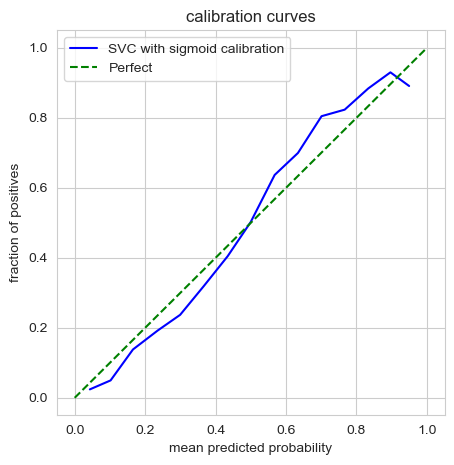

In [ ]:
sigmoid_svc = CalibratedClassifierCV(svc, cv=10, method='sigmoid').fit(s_x_train, s_y_train)
sigmoid_svc_pred = sigmoid_svc.predict_proba(s_x_test)[:, 1]

plt.figure(figsize=(5, 5))

sigm_svc_true_prob, sigm_svc_pred_prob = calibration_curve(s_y_test, sigmoid_svc_pred, n_bins=15)

plt.plot(sigm_svc_pred_prob, sigm_svc_true_prob, label='SVC with sigmoid calibration', color='blue')
plt.plot([0, 1], [0, 1], label='Perfect', linestyle='--', color='green')

plt.xlabel('mean predicted probability')
plt.ylabel('fraction of positives')
plt.title('calibration curves')
plt.legend()
plt.show()

ну кривая явно улучшилась и стала ближе к идеальной

##### __Бонус: Авторское решение__ (0.5 балла)

Реализуйте свою функцию для калибровки вероятностей, используя любой из известных подходов. Кратко опишите ваш подход и продемонстрируйте результаты. Ключевые слова для вдохновения: `Platt`, `Isotonic`.

In [ ]:
#your code here

# Часть 2. Обработка категориальных переменных

Как мы знаем, перекодировать категориальную переменную в список чисел (к примеру 1, 2, 3, ..., n) плохо, поскольку это бы задало на множестве ее значений некоторый порядок, не имеющий смысла.

В этой части мы рассмотрим два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

#### __Подготовка данных__

(бесценный шаг)

Загрузим данные [UCI Adult Dataset](https://archive.ics.uci.edu/ml/datasets/Adult). Этот набор данных содержит информацию о годовых доходах отдельных людей. В качестве признакового описания используется различная информация о человеке (образование, профессия, брачный статус и т.д.). Целевая переменная является бинарной: больше ли годовой доход 50K долларов или нет.

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data

--2022-11-21 18:53:39--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3974305 (3.8M) [application/x-httpd-php]
Saving to: 'adult.data.1'

adult.data.1        100%[===================>]   3.79M   713KB/s    in 6.3s    

2022-11-21 18:53:47 (620 KB/s) - 'adult.data.1' saved [3974305/3974305]



In [ ]:
columns = ['age', 'workclass', 'fnlwgt', 'education',
           'education-num', 'marital-status', 'occupation',
           'relationship', 'race', 'sex', 'capital-gain',
           'capital-loss', 'hours-per-week', 'native-country',
           'income']

df = pd.read_csv('adult.data', header=None, names=columns)
df['income'] = (df['income'] != " <=50K").astype('int32')

In [ ]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify`.

In [ ]:
data_train, data_test = train_test_split(df, test_size=0.25, random_state=777, stratify=df['income'])
data_train, data_validation = train_test_split(data_train, test_size=0.5, random_state=777, stratify=data_train['income'])

#### __Задание 3. OrdinalEncoder__  (0.5 балла)

Закодируйте категориальные признаки с помощью `OrdinalEncoder`, а числовые признаки нормализуйте с помощью `StandardScaler`. Посчитайте качество (в этом задании будем работать c __`AUC-PR`__) при применении логистической регрессии. Замерьте время, потребовавшееся на обучение модели, с учетом кодирования признаков.

In [ ]:
def pipeline(x_train, y_train, x_validation, y_validation, x_test, y_test,
             column_transformer: ColumnTransformer, model_type: ModelTypes, features: list() = None, transformed: bool = False) :

    start = time.monotonic_ns()
    if not transformed:
        transformed_x_train = column_transformer.fit_transform(x_train, y_train)
        transformed_x_validation = column_transformer.transform(x_validation)
        transformed_x_test = column_transformer.transform(x_test)
    else:
        transformed_x_train = x_train
        transformed_x_validation = x_validation
        transformed_x_test = x_test

    if features is None:
        features = [*range(transformed_x_train.shape[1])]
    parameter = find_parameter(transformed_x_train[:, features], y_train, transformed_x_validation[:, features], y_validation, model_type)
    model = model_fit(transformed_x_train[:, features], y_train, model_type, parameter)
    end = time.monotonic_ns()
    total_time = (end - start)/1000000000
    print(f'time needed to train model: {total_time} seconds')


    predicted = model.decision_function(transformed_x_test[:, features])
    precision, recall, _ = precision_recall_curve(y_test, predicted)
    rp_auc = auc(recall, precision)

    return rp_auc, parameter, total_time

In [ ]:
categorical = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
numeric = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

def make_x_y(data, x_columns, y_column):
    return data[x_columns], data[y_column]

x_train, y_train = make_x_y(data_train, categorical + numeric, 'income')
x_validation, y_validation = make_x_y(data_validation, categorical + numeric, 'income')
x_test, y_test = make_x_y(data_test, categorical + numeric, 'income')

In [ ]:
column_transformer = ColumnTransformer([
    ('ohe', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical),
    ('scaling', StandardScaler(), numeric)
])

score, parameter, total_time = pipeline(x_train, y_train, x_validation, y_validation, x_test, y_test,
                                        column_transformer, ModelTypes.LogReg)

df_metrics.loc['(income dataset) Logistic Regression with Ordinal Encoding'] = [ score, None, parameter, total_time ]
df_metrics

best c parameter: 719.6856730011514
time needed to train model: 2.658153417 seconds


,AUC_PR,AUC_ROC,reg_const,time
Random Classifier,0.628598,0.509593,NaN,NaN
Linear SVC,0.825903,0.844337,51.794747,NaN
Logistic Regression,0.824907,0.844776,0.268270,NaN
(income dataset) Logistic Regression with Ordinal Encoding,0.683931,NaN,719.685673,2.658153


ой, че-то совсем какой-то ужас, конечно

__Вопрос__: почему в данном задании мы выбрали метрикой именно `AUC-PR`, а не, к примеру, `AUC-ROC`?

__Ответ__: потому что нам важнее увеличить точность выявления положительной категории. типо если эта модель используется в кредитовании, например, то лучше не дать кредит какой-то части людей, которые его бы отдали, чем дать кому-то лишнему, кто в итоге не закроет кредит

#### __Задание 4. One-Hot Encoding__ (0.5 балла)



Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (в сравнении с тем, что было до кодирования). Измерьте время, потребовавшееся на кодирование категориальных признаков и обучение модели.

In [ ]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical),
    ('scaling', StandardScaler(), numeric)
])

score, parameter, total_time = pipeline(x_train, y_train, x_validation, y_validation, x_test, y_test,
                                        column_transformer, ModelTypes.LogReg)

df_metrics.loc['(income dataset) Logistic Regression with One-Hot Encoding'] = [ score, None, parameter, total_time ]
df_metrics

best c parameter: 0.2682695795279725
time needed to train model: 4.034460416 seconds


,AUC_PR,AUC_ROC,reg_const,time
Random Classifier,0.628598,0.509593,NaN,NaN
Linear SVC,0.825903,0.844337,51.794747,NaN
Logistic Regression,0.824907,0.844776,0.268270,NaN
(income dataset) Logistic Regression with Ordinal Encoding,0.683931,NaN,719.685673,2.658153
(income dataset) Logistic Regression with One-Hot Encoding,0.766717,NaN,0.268270,4.034460


Как можно заметить, one-hot-кодирование может сильно увеличивать количество признаков. Это сказывается на объеме необходимой памяти, особенно, если некоторый признак имеет большое количество значений.


#### __Задание 5. Mean-target Encoding__ (1 балл)

> Проблемы разрастания числа признаков можно избежать в другом способе кодирования категориальных признаков — mean-target encoding (для простоты будем называть это __счётчиками__). Сравним эффективность методов в рамках нашей маркетинговой задачи.

> Основная идея в том, что важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)]}
$$

Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше, без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве.

Сравните время обучения с предыдущими экспериментами (с учетом кодирования признаков).

In [ ]:
from sklearn.preprocessing._encoders import BaseEstimator, TransformerMixin

class MeanTargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None, noise=False, smoothing=False, constant = 10) -> None:
        self._categories = dict()
        self.columns = columns
        self._mean = 0
        self.noise = noise
        self.smoothing = smoothing
        self.constant = constant

    def fit(self, x: pd.DataFrame, y: pd.DataFrame):
        # беру среднее значение по всей выборке,
        # чтобы его класть в неизвестные значения категорий
        self._mean = y.mean()
        for column in self.columns:
            self._categories[column] = dict()
            values = x[column].unique()

            for value in values:
                indexes = x.index[x[column] == value].to_list()
                target = y.loc[indexes].value_counts()
                all = target.sum()
                try:
                    positive = target.loc[1]
                except:
                    positive = 0

                if self.smoothing:
                    all += self.constant
                    positive += self._mean * self.constant

                local_mean = (positive/all)
                if self.noise:
                    local_mean += np.random.normal(scale=0.001, size=1)
                self._categories[column][value] = local_mean

    def transform(self, x: pd.DataFrame):
        temp = x.copy()
        for column in self.columns:
            # смотрю на все значения категории
            values = temp[column].unique()
            for value in values:
                # если какую-то категорию мы не встречали при fit,
                # то просто заменяем ее на среднее по всей выборке
                if value not in self._categories[column].keys():
                    self._categories[column][value] = self._mean
            temp[column] = temp[column].replace(self._categories[column])
        return temp

    def fit_transform(self, x: pd.DataFrame, y: pd.DataFrame):
        self.fit(x, y)
        return self.transform(x)

In [ ]:
column_transformer = ColumnTransformer([
    ('ohe', MeanTargetEncoder(columns=categorical), categorical),
    ('scaling', StandardScaler(), numeric)
])

score, parameter, total_time = pipeline(x_train, y_train, x_validation, y_validation, x_test, y_test,
                                        column_transformer, ModelTypes.LogReg)

df_metrics.loc['(income dataset) Logistic Regression with Mean-target Encoding'] = [ score, None, parameter, total_time ]
df_metrics

best c parameter: 1.0
time needed to train model: 1.134766584 seconds


,AUC_PR,AUC_ROC,reg_const,time
Random Classifier,0.628598,0.509593,NaN,NaN
Linear SVC,0.825903,0.844337,51.794747,NaN
Logistic Regression,0.824907,0.844776,0.268270,NaN
(income dataset) Logistic Regression with Ordinal Encoding,0.683931,NaN,719.685673,2.658153
(income dataset) Logistic Regression with One-Hot Encoding,0.766717,NaN,0.268270,4.034460
(income dataset) Logistic Regression with Mean-target Encoding,0.754950,NaN,1.000000,1.134767


##### __Бонус: Эффективная реализация (1 балл)__

Здесь и далее реализуйте вычисление счетчиков с помощью трансформера (наследуйтесь от классов `BaseEstimator, TransformerMixin` из `sklearn.base`). Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики нужно считать только по обучающей выборке в методе `fit`. Ваш трансформер должен принимать при инициализации список из категориальных признаков и изменять только их.

_______

__Методы борьбы с переобучением счетчиков__


Отметим, что mean-target encoding признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к __переобучению__, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его __целевая метка не использовалась__.

Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки.

#### __Задание 6. Пошумим__  (0.5 балла)

Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям.  При этом постарайтесь найти баланс между борьбой с переобучением и сохранением полезности признаков. Снова обучите логистическую регрессию, оцените качество. Сделайте выводы.

In [ ]:
# я просто добавила дополнительный параметр noise в предыдущую реализацию,
# чтобы не дублировать то же самое

column_transformer = ColumnTransformer([
    ('ohe', MeanTargetEncoder(columns=categorical, noise=True), categorical),
    ('scaling', StandardScaler(), numeric)
])

score, parameter, total_time = pipeline(x_train, y_train, x_validation, y_validation, x_test, y_test,
                                        column_transformer, ModelTypes.LogReg)

df_metrics.loc['(income dataset) Logistic Regression with Mean-target Encoding and noise'] = [ score, None, parameter, total_time ]
df_metrics


best c parameter: 1.0
time needed to train model: 1.105482417 seconds


,AUC_PR,AUC_ROC,reg_const,time
Random Classifier,0.628598,0.509593,NaN,NaN
Linear SVC,0.825903,0.844337,51.794747,NaN
Logistic Regression,0.824907,0.844776,0.268270,NaN
(income dataset) Logistic Regression with Ordinal Encoding,0.683931,NaN,719.685673,2.658153
(income dataset) Logistic Regression with One-Hot Encoding,0.766717,NaN,0.268270,4.034460
(income dataset) Logistic Regression with Mean-target Encoding,0.754950,NaN,1.000000,1.134767
(income dataset) Logistic Regression with Mean-target Encoding and noise,0.754961,NaN,1.000000,1.105482


сделала scale у нормального шума 0.01, потому что я ручками (лень было писать перебор) потыкала несколько разных скейлов и этот выдавал в среднем лучшие результаты, чем все остальные

#### __Задание 7. Сглаживание счетчиков__  (1 балл)

> Теперь ответим на следующий вопрос: что будет, если некоторая категория встречается в выборке всего несколько раз? По этой причине производится сглаживание счётчиков. Например, на практике хорошие результаты показывает использование сглаживания средним по всей выборке:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1] + C \times global\_mean}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)] + C}
$$
где $global\_mean$ — доля объектов положительного класса в выборке, $C$ — параметр, определяющий степень сглаживания (можно использовать 10 или подобрать для каждого признака свой). Идея в том, что мы "разбавляем" среднее значение по категории глобальным средним значением. И тем меньше, чем большее количество объектов этой категории встречается в выборке.

> Вместо среднего значения целевой переменной для сглаживания можно использовать любое другое значение от 0 до 1 (этот параметр иногда называют $prior$). Можно сделать несколько признаков с разными значениями параметра. На практике в задачах бинарной классификации полезными бывают даже отрицательные значения!

Добавьте сглаживание, описанное выше и повторите эксперименты.


In [ ]:
# просто добавила параметр сглаживания в ту же реализацию, аналогично предыдущему

column_transformer = ColumnTransformer([
    ('ohe', MeanTargetEncoder(columns=categorical, smoothing=True), categorical),
    ('scaling', StandardScaler(), numeric)
])

score, parameter, total_time = pipeline(x_train, y_train, x_validation, y_validation, x_test, y_test,
                                        column_transformer, ModelTypes.LogReg)

df_metrics.loc['(income dataset) Logistic Regression with Mean-target Encoding and smoothing'] = [ score, None, parameter, total_time ]
df_metrics

best c parameter: 1.0
time needed to train model: 1.2122655 seconds


,AUC_PR,AUC_ROC,reg_const,time
Random Classifier,0.628598,0.509593,NaN,NaN
Linear SVC,0.825903,0.844337,51.794747,NaN
Logistic Regression,0.824907,0.844776,0.268270,NaN
(income dataset) Logistic Regression with Ordinal Encoding,0.683931,NaN,719.685673,2.658153
(income dataset) Logistic Regression with One-Hot Encoding,0.766717,NaN,0.268270,4.034460
(income dataset) Logistic Regression with Mean-target Encoding,0.754950,NaN,1.000000,1.134767
(income dataset) Logistic Regression with Mean-target Encoding and noise,0.754961,NaN,1.000000,1.105482
(income dataset) Logistic Regression with Mean-target Encoding and smoothing,0.755325,NaN,1.000000,1.212265


#### __Задание 8. И все-таки числовой?__  (0.5 балла)

В данных имеются признаки "возраст" и "число рабочих часов в неделю". Сейчас мы интерпретируем их как числовые, что в общем случае для линейной модели может быть неверной гипотезой. Тем не менее, у этих признаков есть довольно много уникальных значений (сколько?), поэтому применять к ним one-hot кодирование может оказаться излишним. Попробуйте закодировать эти признаки с помощью счетчиков (вместе и по отдельности). Стало ли лучше?



In [ ]:
print(f'unique age values: {len(x_train.age.unique())}')
print(f'unique hours-per-week values: {len(x_train["hours-per-week"].unique())}')

unique age values: 70
unique hours-per-week values: 84


In [ ]:
features = {
    # возраст в категориальных
    0: [
        ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country', 'age'],
        ['fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
        ],
    # количество рабочих часов в неделю в категориальных
    1: [
        ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country', 'hours-per-week'],
        ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss']
        ],
    # оба в категориальных
    2: [
        ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country', 'hours-per-week', 'age'],
        ['fnlwgt', 'education-num', 'capital-gain', 'capital-loss']
        ]
}

names = ['age in categorical', 'hours per week in categorical', 'age and hours per week in categorical']

for i in range(3):
    if i:
        print()
    print(names[i])

    column_transformer = ColumnTransformer([
        ('ohe', MeanTargetEncoder(columns=categorical, smoothing=True), features[i][0]),
        ('scaling', StandardScaler(), features[i][1])
    ])

    score, parameter, total_time = pipeline(x_train, y_train, x_validation, y_validation, x_test, y_test,
                                            column_transformer, ModelTypes.LogReg)

    df_metrics.loc[f'(income dataset) Logistic Regression with Mean-target Encoding and {names[i]}'] = [ score, None, parameter, total_time ]

df_metrics

age in categorical
best c parameter: 1.0
time needed to train model: 5.29073 seconds

hours per week in categorical
best c parameter: 1.0
time needed to train model: 5.295558084 seconds

age and hours per week in categorical
best c parameter: 1.0
time needed to train model: 7.369335 seconds


,AUC_PR,AUC_ROC,reg_const,time
Random Classifier,0.628598,0.509593,NaN,NaN
Linear SVC,0.825903,0.844337,51.794747,NaN
Logistic Regression,0.824907,0.844776,0.268270,NaN
(income dataset) Logistic Regression with Ordinal Encoding,0.683931,NaN,719.685673,2.658153
(income dataset) Logistic Regression with One-Hot Encoding,0.766717,NaN,0.268270,4.034460
(income dataset) Logistic Regression with Mean-target Encoding,0.754950,NaN,1.000000,1.134767
(income dataset) Logistic Regression with Mean-target Encoding and noise,0.754961,NaN,1.000000,1.105482
(income dataset) Logistic Regression with Mean-target Encoding and smoothing,0.755325,NaN,1.000000,1.212265
(income dataset) Logistic Regression with Mean-target Encoding and age in categorical,0.755296,NaN,1.000000,5.290730
(income dataset) Logistic Regression with Mean-target Encoding and hours per week in categorical,0.755171,NaN,1.000000,5.295558


> __Замечание.__ Усложнение методов вычисления счётчиков не делают результаты модели гарантированно лучше. Особенно с учётом того, что логистическая регрессия не такая сложная модель, чтобы переобучаться. Поэтому вы необязательно должны были получать на каждом шаге всё лучшие и лучшие результаты (но необходимые результаты у вас должны были получиться).

Как мы могли пронаблюдать, счётчики являются конкурентной альтернативой one-hot-кодированию. Опишите, какие плюсы и минусы использования счётчиков по сравнению с one-hot-кодированием вы заметили.

__Ответ:__ во-первых, счетчики надо реализовывать самой, что очень неприятно, ставлю дизлайк. но зато много возможностей для ручной настройки. результат, конечно, не особо отличается, но, думаю, если поподбирать параметры кросс-валидацией, то можно сделать крутые счетчики

# Часть 3. Отбор признаков

Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом их расчёт занимает время) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.

Обратимся к тем же данным про предсказание дохода.

In [ ]:
columns = ['age', 'workclass', 'fnlwgt', 'education',
           'education-num', 'marital-status', 'occupation',
           'relationship', 'race', 'sex', 'capital-gain',
           'capital-loss', 'hours-per-week', 'native-country',
           'income']

df = pd.read_csv('adult.data', header=None, names=columns)
df['income'] = (df['income'] != " <=50K").astype('int32')

Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify`.

In [ ]:
data_train, data_test = train_test_split(df, test_size=0.25, random_state=777, stratify=df['income'])
data_train, data_validation = train_test_split(data_train, test_size=0.5, random_state=777, stratify=data_train['income'])

Давайте закодируем все категориальные признаки с помощью One-hot Encoding, считая возраст и число часов числовыми. Сколько новых признаков мы получим?

In [ ]:
categorical = ['workclass', 'education', 'marital-status', 'occupation',
               'relationship', 'race', 'sex', 'native-country', 'age', 'hours-per-week']
numeric = ['fnlwgt', 'education-num', 'capital-gain', 'capital-loss']

x_train, y_train = make_x_y(data_train, categorical + numeric, 'income')
x_validation, y_validation = make_x_y(data_validation, categorical + numeric, 'income')
x_test, y_test = make_x_y(data_test, categorical + numeric, 'income')

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical),
    ('scaling', StandardScaler(), numeric)
], remainder='passthrough')

In [ ]:
transformed = column_transformer.fit_transform(x_train, y_train)
print(f'new features added: {(transformed.shape[1] - x_train.shape[1])}')

new features added: 245


В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — `AUC-PR`. Обучите модель и посчитайте качество на тестовой выборке. Давайте запомним полученное значение.

In [ ]:

score, parameter, total_time = pipeline(x_train, y_train, x_validation, y_validation, x_test, y_test,
                                        column_transformer, ModelTypes.LogReg)

df_metrics.loc['(income dataset, age and hours in categorical) Logistic Regression with One-Hot Encoder'] = [ score, None, parameter, total_time ]
df_metrics

best c parameter: 0.2682695795279725
time needed to train model: 5.150182834 seconds


,AUC_PR,AUC_ROC,reg_const,time
Random Classifier,0.628598,0.509593,NaN,NaN
Linear SVC,0.825903,0.844337,51.794747,NaN
Logistic Regression,0.824907,0.844776,0.268270,NaN
(income dataset) Logistic Regression with Ordinal Encoding,0.683931,NaN,719.685673,2.658153
(income dataset) Logistic Regression with One-Hot Encoding,0.766717,NaN,0.268270,4.034460
(income dataset) Logistic Regression with Mean-target Encoding,0.754950,NaN,1.000000,1.134767
(income dataset) Logistic Regression with Mean-target Encoding and noise,0.754961,NaN,1.000000,1.105482
(income dataset) Logistic Regression with Mean-target Encoding and smoothing,0.755325,NaN,1.000000,1.212265
(income dataset) Logistic Regression with Mean-target Encoding and age in categorical,0.755296,NaN,1.000000,5.290730
(income dataset) Logistic Regression with Mean-target Encoding and hours per week in categorical,0.755171,NaN,1.000000,5.295558


ну качество немного улучшилось по сравнению с вариантом, где age и hours-per-week в числовых и используется one-hot encoder

#### __Задание 9. Встроенные методы (0.5 балла)__

Допустим, мы хотим оставить только 40 лучших признаков. Попробуем сделать это несколькими способами.

Начнём с отборам признаков с помощью линейной модели. Как известно, веса линейной модели означают вклад каждого признака в предсказание модели, а значит, модуль этого вклада можно интерпретировать как важность признаков. Такой метод отбора называются встроенным или embedded method, так как он заложен в особенности модели.

Оставьте 40 признаков с наибольшим модулем соответствующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков.



In [ ]:
from sklearn.linear_model import Ridge

def select(column_transformer: ColumnTransformer) -> list:
    start = time.monotonic_ns()

    pipeline = Pipeline(steps=[
        ('transform', column_transformer),
        ('regression', Ridge())
    ])

    model = pipeline.fit(x_train, y_train)
    coefs = model['regression'].coef_

    # нижняя граница, по которой отбираем коэффициент при признаках
    top40 = sorted(coefs)[-40:][0]

    indexes = list()
    for i in range(len(coefs)):
        if coefs[i] >= top40:
            indexes.append(i)

    end = time.monotonic_ns()
    my_time = (end - start)/1000000000
    print(f"indexes of selected features: {indexes}")
    print(f"time needed to select features: {(end - start)/1000000000}")

    return my_time, indexes


In [ ]:
my_time, indexes = select(column_transformer)
score, parameter, total_time = pipeline(x_train, y_train, x_validation, y_validation, x_test, y_test,
                                        column_transformer, ModelTypes.LogReg, indexes)

df_metrics.loc['(income dataset, age and hours in categorical) Logistic Regression with One-Hot Encoder and 40 selected features'] = [ score, None, parameter, total_time + my_time]
df_metrics

indexes of selected features: [1, 19, 26, 36, 43, 52, 61, 62, 70, 83, 95, 129, 131, 132, 134, 135, 138, 143, 145, 162, 209, 214, 216, 217, 220, 222, 223, 225, 226, 227, 228, 229, 231, 235, 242, 243, 246, 248, 250, 252]
time needed to select features: 0.053020458
best c parameter: 1.0
time needed to train model: 1.272496792 seconds


,AUC_PR,AUC_ROC,reg_const,time
Random Classifier,0.628598,0.509593,NaN,NaN
Linear SVC,0.825903,0.844337,51.794747,NaN
Logistic Regression,0.824907,0.844776,0.268270,NaN
(income dataset) Logistic Regression with Ordinal Encoding,0.683931,NaN,719.685673,2.658153
(income dataset) Logistic Regression with One-Hot Encoding,0.766717,NaN,0.268270,4.034460
(income dataset) Logistic Regression with Mean-target Encoding,0.754950,NaN,1.000000,1.134767
(income dataset) Logistic Regression with Mean-target Encoding and noise,0.754961,NaN,1.000000,1.105482
(income dataset) Logistic Regression with Mean-target Encoding and smoothing,0.755325,NaN,1.000000,1.212265
(income dataset) Logistic Regression with Mean-target Encoding and age in categorical,0.755296,NaN,1.000000,5.290730
(income dataset) Logistic Regression with Mean-target Encoding and hours per week in categorical,0.755171,NaN,1.000000,5.295558


Изменилось ли качество? Как?

качество хуже всех предыдущих вариантов))

Подумаем, что мы не учли. Мы действовали в предположении, что признаки вносят вклад равномерно, и не учитывали их масштаб. Если мы умножим один из признаков в 100 раз, то без учёта регуляризации его вес уменьшится в эти же 100 раз. А мы на основе этого отбираем признаки! Давайте сначала отмасштабируем признаки одним из способов, а только потом будем удалять признаки.

Кстати, в таком случае надо пересчитать качество на всех признаках (сделайте это ниже). Если вы сделали нормирование признаков в самом начале, то попробуйте отобрать признаки на неотмасштабированных данных.

Что получилось?

ну я скейлила вообще-то, так что попробуем без скейла

In [ ]:
no_scale_column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical)
], remainder='passthrough')

my_time, indexes = select(no_scale_column_transformer)
score, parameter, total_time = pipeline(x_train, y_train, x_validation, y_validation, x_test, y_test,
                                        no_scale_column_transformer, ModelTypes.LogReg, indexes)

df_metrics.loc['(income dataset, age and hours in categorical) Logistic Regression with One-Hot Encoder without scale and 40 selected features'] = [ score, None, parameter, total_time + my_time]
df_metrics

indexes of selected features: [1, 2, 5, 7, 18, 19, 21, 23, 27, 36, 42, 43, 44, 47, 52, 57, 59, 98, 121, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 143, 215, 220, 225, 230, 256, 257, 258]
time needed to select features: 0.028465125
best c parameter: 10000.0
time needed to train model: 6.54963025 seconds


,AUC_PR,AUC_ROC,reg_const,time
Random Classifier,0.628598,0.509593,NaN,NaN
Linear SVC,0.825903,0.844337,51.794747,NaN
Logistic Regression,0.824907,0.844776,0.268270,NaN
(income dataset) Logistic Regression with Ordinal Encoding,0.683931,NaN,719.685673,2.658153
(income dataset) Logistic Regression with One-Hot Encoding,0.766717,NaN,0.268270,4.034460
(income dataset) Logistic Regression with Mean-target Encoding,0.754950,NaN,1.000000,1.134767
(income dataset) Logistic Regression with Mean-target Encoding and noise,0.754961,NaN,1.000000,1.105482
(income dataset) Logistic Regression with Mean-target Encoding and smoothing,0.755325,NaN,1.000000,1.212265
(income dataset) Logistic Regression with Mean-target Encoding and age in categorical,0.755296,NaN,1.000000,5.290730
(income dataset) Logistic Regression with Mean-target Encoding and hours per week in categorical,0.755171,NaN,1.000000,5.295558


Вопрос на засыпку: one-hot кодирование возвращает нам единичные признаки-индикаторы. Попробуйте также отскалировать их, как и обычные числовые, и снова выбрать 40 главных по вкладу признаков. Изменился ли их список? Изменится ли качество?

In [ ]:
features = numeric + categorical

trans_x = no_scale_column_transformer.fit_transform(x_train, y_train)
length = trans_x.shape[1]

scale_column_transformer = ColumnTransformer([
    ('scale', StandardScaler(with_mean=False), [*range(length)])
], remainder='passthrough')


def select(first_column_transformer: ColumnTransformer, second_column_tranformet: ColumnTransformer) -> list:
    start = time.monotonic_ns()

    pipeline = Pipeline(steps=[
        ('first transform', first_column_transformer),
        ('second transform', second_column_tranformet),
        ('regression', Ridge())
    ])

    model = pipeline.fit(x_train, y_train)
    coefs = model['regression'].coef_

    # нижняя граница, по которой отбираем коэффициент при признаках
    top40 = sorted(coefs)[-40:][0]

    indexes = list()
    for i in range(len(coefs)):
        if coefs[i] >= top40:
            indexes.append(i)

    end = time.monotonic_ns()
    my_time = (end - start)/1000000000
    print(f"indexes of selected features: {indexes}")
    print(f"time needed to select features: {(end - start)/1000000000}")

    return my_time, indexes


my_time, indexes = select(no_scale_column_transformer, scale_column_transformer)
score, parameter, total_time = pipeline(x_train, y_train, x_validation, y_validation, x_test, y_test,
                                        column_transformer, ModelTypes.LogReg, indexes)

df_metrics.loc['(income dataset, age and hours in categorical) Logistic Regression with One-Hot Encoder, scaling categorical and 40 selected features'] = [ score, None, parameter, total_time + my_time]
df_metrics

indexes of selected features: [1, 5, 18, 19, 21, 23, 27, 36, 42, 43, 45, 47, 52, 59, 121, 123, 124, 127, 128, 129, 130, 131, 132, 134, 135, 136, 137, 138, 143, 145, 214, 215, 220, 225, 226, 235, 246, 256, 257, 258]
time needed to select features: 0.031334625
best c parameter: 3.727593720314938
time needed to train model: 0.936121292 seconds


,AUC_PR,AUC_ROC,reg_const,time
Random Classifier,0.628598,0.509593,NaN,NaN
Linear SVC,0.825903,0.844337,51.794747,NaN
Logistic Regression,0.824907,0.844776,0.268270,NaN
(income dataset) Logistic Regression with Ordinal Encoding,0.683931,NaN,719.685673,2.658153
(income dataset) Logistic Regression with One-Hot Encoding,0.766717,NaN,0.268270,4.034460
(income dataset) Logistic Regression with Mean-target Encoding,0.754950,NaN,1.000000,1.134767
(income dataset) Logistic Regression with Mean-target Encoding and noise,0.754961,NaN,1.000000,1.105482
(income dataset) Logistic Regression with Mean-target Encoding and smoothing,0.755325,NaN,1.000000,1.212265
(income dataset) Logistic Regression with Mean-target Encoding and age in categorical,0.755296,NaN,1.000000,5.290730
(income dataset) Logistic Regression with Mean-target Encoding and hours per week in categorical,0.755171,NaN,1.000000,5.295558


#### __Задание 10. Методы фильтрации (0.5 балла)__


Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods.

В качестве такой функции будем считать t-статистику:

$$t(j) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $\mu$, $\sigma$, $n$ соответственно среднее, стандартное отклонение и количество объектов каждого из классов.

Оставьте 40 признаков с наибольшим значением $t$, замерьте качество и скорость отбора признаков.



In [ ]:
def select(column_transformer: ColumnTransformer, x_train, y_train):
    start = time.monotonic_ns()
    mask_pos = (y_train == 1).to_list()
    mask_neg = (y_train == 0).to_list()

    values = y_train.value_counts()
    positive_count = values[1]
    negative_count = values[0]
    sum = positive_count + negative_count

    transformed_x = pd.DataFrame(column_transformer.fit_transform(x_train).toarray())
    filter = list()
    for name, column in transformed_x.items():
        positive = column[mask_pos]
        negative = column[mask_neg]
        filter.append(
            np.abs(positive.mean() - negative.mean()) / (
                np.sqrt(
                    (positive_count * (np.std(positive) ** 2)
                        + negative_count * (np.std(negative) ** 2)) / sum
                        )
            )
        )

    top40 = sorted(filter)[-40:][0]
    mask = (filter >= top40)
    end = time.monotonic_ns()
    my_time = (end - start)/1000000000
    print(f"time needed to select features: {(end - start)/1000000000}")

    return my_time, mask

my_time, mask = select(column_transformer, x_train, y_train)
score, parameter, total_time = pipeline(x_train, y_train, x_validation, y_validation, x_test, y_test,
                                        column_transformer, ModelTypes.LogReg, mask)

df_metrics.loc['(income dataset, age and hours in categorical) Logistic Regression \
               with One-Hot Encoder and 40 selected by t func features'] = [ score, None, parameter, total_time + my_time]
df_metrics


time needed to select features: 0.456741208
best c parameter: 0.2682695795279725
time needed to train model: 2.419958916 seconds


,AUC_PR,AUC_ROC,reg_const,time
Random Classifier,0.628598,0.509593,NaN,NaN
Linear SVC,0.825903,0.844337,51.794747,NaN
Logistic Regression,0.824907,0.844776,0.268270,NaN
(income dataset) Logistic Regression with Ordinal Encoding,0.683931,NaN,719.685673,2.658153
(income dataset) Logistic Regression with One-Hot Encoding,0.766717,NaN,0.268270,4.034460
(income dataset) Logistic Regression with Mean-target Encoding,0.754950,NaN,1.000000,1.134767
(income dataset) Logistic Regression with Mean-target Encoding and noise,0.754961,NaN,1.000000,1.105482
(income dataset) Logistic Regression with Mean-target Encoding and smoothing,0.755325,NaN,1.000000,1.212265
(income dataset) Logistic Regression with Mean-target Encoding and age in categorical,0.755296,NaN,1.000000,5.290730
(income dataset) Logistic Regression with Mean-target Encoding and hours per week in categorical,0.755171,NaN,1.000000,5.295558


#### __Задание 11. Методы-обёртки__ (1 балл)

Третий из рассматриваемых нами методов работает следующим образом: мы исключаем по очереди один из признаков и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не окажется выполненым некоторое условие (количество признаков или ухудшение качества). Более конкретно, на каждом шаге мы будем удалять такой признак $j$, что качество модели на множестве оставшихся признаков без $j$ максимально, то есть удалять мы будем наиболее бесполезный признак.

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите обучающую выборку на 2 части, на одной из них обучайте модель без одного из признаков,  на второй части оценивайте качество. Исходную тестовую выборку стоит использовать только для финальной оценки качества.

Снова оставьте только 40 признаков и оцените качество на тестовой выборке. Сколько времени занял такой отбор признаков?

In [ ]:
start = time.monotonic_ns()

transformed_x_train = column_transformer.fit_transform(x_train, y_train)
transformed_x_validation = column_transformer.transform(x_validation)

count = transformed_x_train.shape[1]
features = [True] * count

for i in range(count - 40):
    best_index = 0
    best_score = 0
    for j in range(count):
        if features[j]:
            features[j] = False
            model = model_fit(transformed_x_train[:, features], y_train, ModelTypes.LogReg)
            precision, recall, _ = precision_recall_curve(y_validation, model.decision_function(transformed_x_validation[:, features]))
            score = auc(recall, precision)
            if score > best_score:
                best_score = score
                best_index = j
            features[j] = True
    features[best_index] = False
    print(f"{i} features excluded")

model = model_fit(transformed_x_train[:, features], y_train, ModelTypes.LogReg)

end = time.monotonic_ns()
total_time = (end - start)/1000000000
print(f"time needed to select features and to train final model: {total_time}")

transformed_x_test = column_transformer.transform(x_test)
precision, recall, _ = precision_recall_curve(y_test, model.decision_function(transformed_x_test[:, features]))
pr_auc = auc(recall, precision)

df_metrics.loc['(income dataset, age and hours in categorical) LogReg, One-Hot, Scale, deleting features'] = [
    pr_auc,
    None,
    None,
    total_time
]

Стоит отметить, что с помощью такого метода можно пойти и в обратную сторону. Попробуйте _добавлять_ по одному самому полезному признаку в выборку до тех пор, пока не наберется 40 штук. Найдется ли порог, при котором добавление следующих признаков будет только ухудшать качество модели?

In [ ]:
start = time.monotonic_ns()

transformed_x_train = column_transformer.fit_transform(x_train, y_train)
transformed_x_validation = column_transformer.transform(x_validation)

count = transformed_x_train.shape[1]
features = [False] * count

for i in range(40):
    best_index = 0
    best_score = 0
    for j in range(count):
        if not features[j]:
            features[j] = True
            model = model_fit(transformed_x_train[:, features], y_train, ModelTypes.LogReg)
            precision, recall, _ = precision_recall_curve(y_validation, model.decision_function(transformed_x_validation[:, features]))
            score = auc(recall, precision)
            if score > best_score:
                best_score = score
                best_index = j
            features[j] = False
    print(f"best score after adding {i + 1} features: {best_score}")
    features[best_index] = True

model = model_fit(transformed_x_train[:, features], y_train, ModelTypes.LogReg)

end = time.monotonic_ns()
total_time = (end - start)/1000000000
print(f"time needed to select features and to train final model: {total_time}")

transformed_x_test = column_transformer.transform(x_test)
precision, recall, _ = precision_recall_curve(y_test, model.decision_function(transformed_x_test[:, features]))
pr_auc = auc(recall, precision)

df_metrics.loc['(income dataset, age and hours in categorical) LogReg, One-Hot, Scale, adding features'] = [
    pr_auc,
    None,
    None,
    total_time
]

df_metrics

best score after adding 1 features: 0.6682388597987414
best score after adding 2 features: 0.6715400290237967
best score after adding 3 features: 0.6740008242628547
best score after adding 4 features: 0.6763982138181659
best score after adding 5 features: 0.6796066458542006
best score after adding 6 features: 0.7252288917441911
best score after adding 7 features: 0.7385064318443868
best score after adding 8 features: 0.7436767594754291
best score after adding 9 features: 0.7471192288269917
best score after adding 10 features: 0.7489709927807302
best score after adding 11 features: 0.7502651024827398
best score after adding 12 features: 0.751500295508057
best score after adding 13 features: 0.7527754669473868
best score after adding 14 features: 0.7538167567803084
best score after adding 15 features: 0.7547701499342067
best score after adding 16 features: 0.7556895241766558
best score after adding 17 features: 0.756706947038931
best score after adding 18 features: 0.7577605848736113
bes

,AUC_PR,AUC_ROC,reg_const,time
Random Classifier,0.628598,0.509593,NaN,NaN
Linear SVC,0.825903,0.844337,51.794747,NaN
Logistic Regression,0.824907,0.844776,0.268270,NaN
(income dataset) Logistic Regression with Ordinal Encoding,0.683931,NaN,719.685673,2.658153
(income dataset) Logistic Regression with One-Hot Encoding,0.766717,NaN,0.268270,4.034460
(income dataset) Logistic Regression with Mean-target Encoding,0.754950,NaN,1.000000,1.134767
(income dataset) Logistic Regression with Mean-target Encoding and noise,0.754961,NaN,1.000000,1.105482
(income dataset) Logistic Regression with Mean-target Encoding and smoothing,0.755325,NaN,1.000000,1.212265
(income dataset) Logistic Regression with Mean-target Encoding and age in categorical,0.755296,NaN,1.000000,5.290730
(income dataset) Logistic Regression with Mean-target Encoding and hours per week in categorical,0.755171,NaN,1.000000,5.295558


я следила, пока обучалась моделька. при максимуме в 40 признаков не возникает момента, когда при добавлении нового, качество модели уменьшается.

Давайте подведём итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству?

**Ответ:** метод, когда надо убирать признаки -- просто отпвратительный, он работает сто миллионов лет, зачем он нужен... когда добавляем признаки, то получается лучше и быстрее -- хорошо работающий жадный метод, но долго относительно других. лучше всех вообще работал самый базовый, без сложностей one-hot encoder без отбора признаков))

# Часть 4. Оценка экономического эффекта модели

> В данной части мы займемся тем, что от вас скорее всего потребуется на реальной работе (помимо перекладки `json`, разумеется). А именно:
- мы соберем несколько специализированных метрик качества,
- попытаемся настроить модель на максимизацию _прибыли_,
- оценим, сколько вообще получится заработать на этом.

> Разумеется, здесь будет сделано множество упрощающих жизнь допущений, но обо всем по порядку. Если вы всё прослушали на экономике, то напомним, что выручка — это сколько денег нам принесли клиенты, а прибыль — выручка за вычетом расходов на зарплату и прочее.


#### __Задание 12. Прогноз по доходам и расходам__ (1 балл)

В этой части мы будем работать с данными [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing). Этот датасет содержит информацию о банковском телефонном маркетинге.

__Объектом__ здесь является телефонный звонок потенциальному клиенту с предложением некоторой услуги (утверждается, что это краткосрочный депозит). В качестве признакового описания используются характеристики клиента (образование, брак и т.д.), данные о звонке и различные экономические индикаторы - более подробная информация представлена в файле `bank-additional-names.txt`.
__Целевая переменная__ - ответ клиента (согласился ли он открыть депозит?)

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
!unzip bank-additional.zip
data = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

--2022-11-21 19:12:41--  https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 444572 (434K) [application/x-httpd-php]
Saving to: 'bank-additional.zip.1'

bank-additional.zip 100%[===================>] 434.15K   160KB/s    in 2.7s    

2022-11-21 19:12:45 (160 KB/s) - 'bank-additional.zip.1' saved [444572/444572]

Archive:  bank-additional.zip
replace bank-additional/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [ ]:
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [ ]:
x = data.drop(columns=['duration', 'y'])
y = (data.y == 'yes')

В этой части не нужно делить выборку - мы будем использовать кросс-валидацию.  Используйте 5 фолдов, сделайте `shuffle=True, random_state=500`. По кросс-валидации у вас получится 5 вариантов обучающей и тестовой выборки.

In [ ]:
categorical = ['job', 'marital', 'education', 'default', 'housing',
               'loan', 'contact', 'month', 'day_of_week', 'poutcome']
numeric = ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate',
           'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

column_transformer = ColumnTransformer([
        ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical),
        ('scaler', StandardScaler(), numeric)
    ]
)

Обучите логистическую регрессию на каждой обучающей выборке (воспользуйтесь one-hot для категориальных признаков и `StandardScaler` для числовых, гиперпараметры по умолчанию) и сделайте предсказания для соответствующих тестовых выборок.

In [ ]:
from sklearn.model_selection import KFold

transformed = column_transformer.fit_transform(x)

folds = KFold(n_splits=5, shuffle=True, random_state=69)

def predict(folds, x, y, parameter = 0.1):
    predicted = np.array([0] * y.shape[0])
    for train, test in folds.split(x):
        model = model_fit(x[train], y[train], ModelTypes.LogReg, parameter)
        predicted[test] = model.predict(x[test])
    return predicted

predicted = predict(folds, transformed, y)

Допустим, работники вашего колл-центра получают за один звонок клиенту 1 доллар. При согласии клиента на предлагаемые условия он принесет в банк 10 долларов. Предположим, что всем положительным прогнозам ваши сотрудники решили позвонить. Посчитайте на всех тестовых выборках выручку и усредните. Также вычислите стандартное отклонение.
- Сколько денег вы в среднем заработаете?
- Сколько из заработанных денег придётся отдать операторам вашего колл-центра?

In [ ]:
calls = list()
revenue = list()

for train, test in folds.split(transformed):
    calls.append(predicted[test].sum())
    revenue.append(y[test][(predicted[test] == 1)].sum() * 10)

mean_calls = np.mean(calls)
mean_revenue = np.mean(revenue)

print(f"mean revenue: {np.mean(revenue)}")
print(f"deviation: {np.std(revenue)}")
print(f"mean salaries: {np.mean(calls)}")


mean revenue: 2098.0
deviation: 110.70682002478438
mean salaries: 313.6


Внесем некоторую долю случайности. Пусть теперь согласный на условия клиент будет приносить не 10 долларов, а случайную величину, равномерно распределенную в интервале $[0;20)$. Проделайте все те же самые действия. Для имитации реальной ситуации **НЕ** фиксируйте `random_seed` при подсчете выручки с клиента. Что получилось?

In [ ]:
def count_calls_revenues(folds, x, y, predicted):
    calls = list()
    revenue = list()

    for train, test in folds.split(transformed):
        calls.append(predicted[test].sum())
        revenue.append(y[test][(predicted[test] == 1)].sum() * np.random.uniform(low=0.0, high=20.0))

    return np.mean(calls), np.mean(revenue), np.std(revenue)

mean_calls, mean_revenue, deviation_revenue = count_calls_revenues(folds, transformed, y, predicted)
print(f"mean revenue: {mean_revenue}")
print(f"deviation: {deviation_revenue}")
print(f"mean salaries: {mean_calls}")

mean revenue: 1857.6520843093695
deviation: 1327.0686433740766
mean salaries: 313.6


Настройте по кросс-валидации коэффициент регуляризации модели для максимизации прибыли (считайте как случайную величину выше). Удалось ли получить какой-то выигрыш? При каком коэффициенте регуляризациии прибыль максимальна? Постройте график зависимости ожидаемой прибыли от коэффициента, укажите стандартные отклонения (вам поможет `plt.errorbar`, [пример](https://jakevdp.github.io/PythonDataScienceHandbook/04.03-errorbars.html)).

best parameter: 1.8329807108324339
best profit: 3107.286442372613


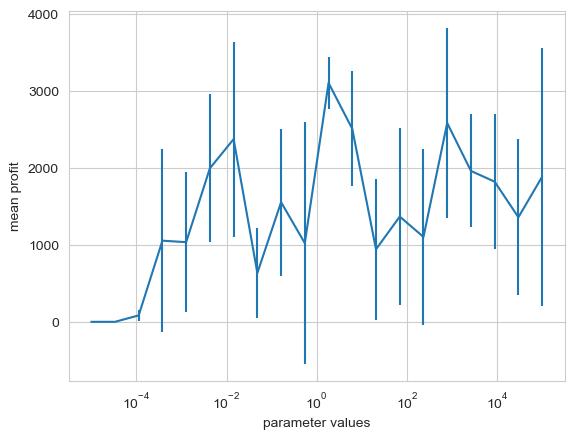

In [ ]:
def draw_error_bar(folds, x, y):
    x_dots = list()
    y_dots = list()
    deviations = list()

    parameters = np.logspace(-5, 5, 20)
    best_parameter = 0
    best_score = 0

    for parameter in parameters:
        predicted = predict(folds, x, y, parameter)
        calls, revenue, deviation = count_calls_revenues(folds, x, y, predicted)

        score = revenue - calls
        if score > best_score:
            best_parameter = parameter
            best_score = score

        x_dots.append(parameter)
        y_dots.append(score)
        deviations.append(deviation)

    print(f"best parameter: {best_parameter}")
    print(f"best profit: {best_score}")
    plt.errorbar(x_dots, y_dots, deviations)
    plt.xscale('log')
    plt.xlabel('parameter values')
    plt.ylabel('mean profit')
    plt.show()


draw_error_bar(folds, transformed, y)

Попробуйте запустить перебор несколько раз. Находится ли каждый раз один и тот же "лучший" коэффициент? Присутствует ли какая-то закономерность? Какие вы можете сделать из этого выводы?

best parameter: 69.51927961775606
best profit: 2556.1723420917765


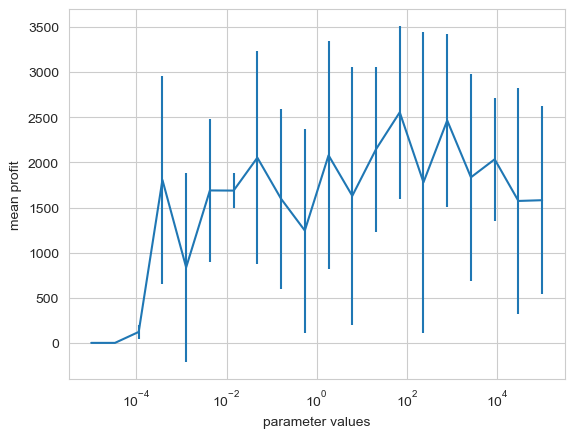

best parameter: 8858.667904100832
best profit: 2210.7214124587845


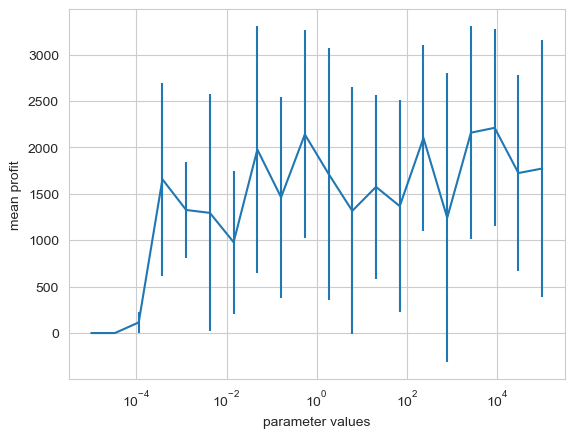

best parameter: 2636.6508987303555
best profit: 2595.3834266252734


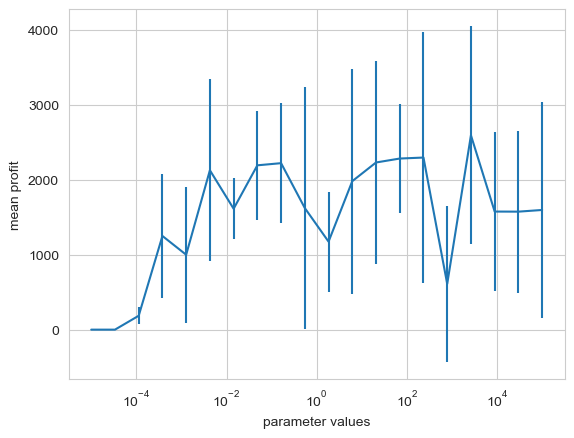

In [ ]:
for i in range(3):
    draw_error_bar(folds, transformed, y)

можно заметить, что значение параметра каждый раз разное. еще и дисперсия огромная. так что, кажется, закономерность найти сложно. но лучший профит всегда примерно около одного значения

#### __Задание 13. Ключевая метрика__ (1 балл)

Выше мы уже описали примерную экономическую модель вашей задачи. Как вы считаете, что для вашего бизнеса важнее — хороший precision или recall модели? Почему?

__Ответ:__ нам важнее precision, потому что не хочется тратить лишние деньги на звонки, которые на самом деле не окупятся. лучше позвонить мало, но с большей точностью, чем звонить много, обзвонить всех, кто заплатит деньги, но при этом потратить много денег на зарплату сотруднкиам



> Вспомним, что на самом деле логистическая регрессия предсказывает нам вероятности положительного класса для объекта. Возможно, путем настройки __порога бинаризации__ этих вероятностей мы сможем получить какой-то выигрыш?

Проверьте ваши рассуждения выше с помощью настройки порога бинаризации на кросс-валидации для максимизации прибыли. Воспользуйтесь сеткой от 0 до 1 с шагом 0.01. Напомним, что снижение порога дает нам более высокий recall и более низкий precision, и наоборот.

best threshold: 0.15789473684210525
best profit: 4834.438579880756


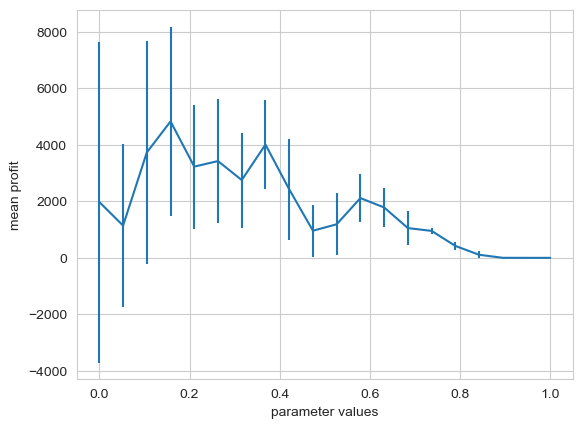

In [ ]:
def predict_with_threshold(folds, x, y, threshold):
    predicted = np.array([0] * y.shape[0])
    for train, test in folds.split(x):
        model = model_fit(x[train], y[train], ModelTypes.LogReg)
        predicted[test] = (model.predict_proba(x[test])[:, 1] >= threshold)
    return predicted

def draw_find_threshold(folds, x, y):
    x_dots = list()
    y_dots = list()
    deviations = list()

    parameters = np.linspace(0, 1.0, 20)  # я понимаю, что тут должно быть 1000 вместо 100,
                                           # но это так долго обучается, что уже нет в этом смысла
    best_parameter = 0
    best_score = 0

    for parameter in parameters:
        predicted = predict_with_threshold(folds, x, y, parameter)
        calls, revenue, deviation = count_calls_revenues(folds, x, y, predicted)

        score = revenue - calls
        if score > best_score:
            best_parameter = parameter
            best_score = score

        x_dots.append(parameter)
        y_dots.append(score)
        deviations.append(deviation)

    print(f"best threshold: {best_parameter}")
    print(f"best profit: {best_score}")
    plt.errorbar(x_dots, y_dots, deviations)
    plt.xlabel('parameter values')
    plt.ylabel('mean profit')
    plt.show()

draw_find_threshold(folds, transformed, y)

Постройте график зависимости прибыли от порога бинаризации, также отметьте на нем стандартные отклонения. Выделите наилучший порог.


__Вопрос:__ Замечаете ли вы какую-то закономерность? Для правильного ответа на этот вопрос попробуйте запустить несколько раз и задумайтесь, почему порог получается в какой-то конкретной области?

best threshold: 0.21052631578947367
best profit: 7044.747902411441


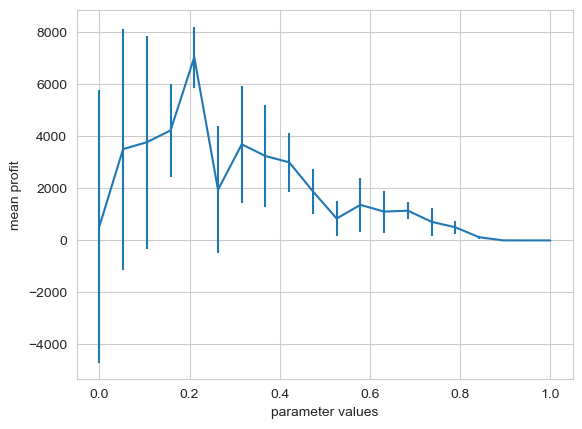

best threshold: 0.21052631578947367
best profit: 4656.551714402052


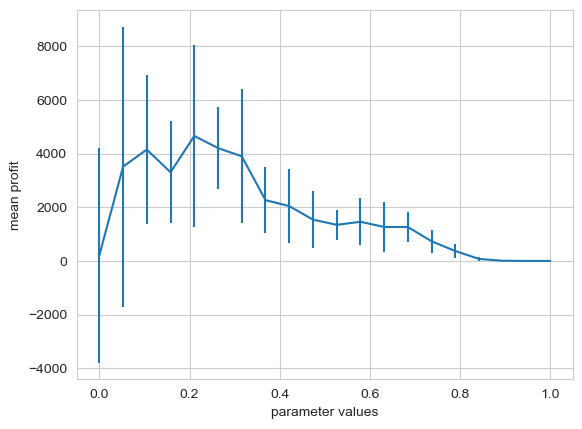

In [ ]:
for i in range(3):
    draw_find_threshold(folds, transformed, y)

оптимальное значение получается где-то в районе 0.1-0.2. видимо, в силу того, что один звонок стоит очень дешево относительно получаемой выручки с продажи, звонок где-то в 10 раз дешевле среднего чека, то мы можем меньше 9 раз ошибиться и не уйти в минус. поэтому оптимальный порог и такой низкий

Каковы значения precision и recall на выбранном пороге? Оцените по кросс-валидации. Также вычислите стандартное отклонение.

In [ ]:
from sklearn.metrics import precision_score, recall_score

def precision_recall(folds, x, y, predicted):

    precisions = list()
    recalls = list()

    for train, test in folds.split(transformed):
        recalls.append(recall_score(y[test], predicted[test]))
        precisions.append(precision_score(y[test], predicted[test]))

    return precisions, recalls

precisions, recalls = precision_recall(folds, transformed, y, predicted = predict_with_threshold(folds, transformed, y, 0.17))
print(f"precision\nmean: {np.mean(precisions)}, deviation: {np.std(precisions)}")
print(f"recall\nmean: {np.mean(recalls)}, deviation: {np.std(recalls)}")

precision
mean: 0.40326990603702983, deviation: 0.01593723652859149
recall
mean: 0.5877973227852041, deviation: 0.019747323601793987


Можно пронаблюдать, что наша модель склоняется к более высокому recall. Попробуйте оценить качество модели с помощью `PR-AUC` в зоне recall $\geq$ 0.5. Сделайте это следующим образом:
- выберите только те пороги, на которых достигается необходимый recall,
- затем интерпретируйте отсеченный в единичном квадрате прямоугольник как новый единичный квадрат,
- посчитайте площадь под отсеченной кривой

In [ ]:
precision = list()
recall = list()

for parameter in np.linspace(0, 1, 100):
    precisions, recalls = precision_recall(folds, transformed, y, predicted = predict_with_threshold(folds, transformed, y, parameter))

    pr = np.mean(precisions)
    rec = np.mean(recalls)

    # print(f"parameter: {parameter}, mean precision: {pr}, mean recall: {rec}")

    if rec < 0.5:
        break

    precision.append(pr)
    recall.append(rec)

pr_max = np.max(precision)
pr_min = np.min(precision)
shifted_precision = (precision - pr_min) / (pr_max - pr_min)
rec_max = np.max(recall)
rec_min = np.min(recall)
shifted_recall = (recall - rec_min) / (rec_max - rec_min)
print(f"PR-AUC: {auc(shifted_recall, shifted_precision)}")


ROC-AUC: 0.4083978821668133
